In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
import animatplot as amp

In [2]:
@numba.jit(nopython=True)

# this function determines the coupling energy based on the location of the spin
def rates_2d_numba(J,H,state,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field))

## Feedback Through (De)methylation

So far, it seems that we have incorporated the effect of the ligand concentration well, because the system shows cooperativity whilst retaining some desirable features of the Ising model, such as a continuous phase transition in $J$. We now move on to making our model adaptive. Concretely, when presented with a step change in concentration, bacteria initially change activity levels, but after some time, they recover their pre-stimulus activity level. This means there must be some type of feedback mechanism to recover the baseline activity.

This mechanism is (de)methylation of the receptors, which shifts the equilibrium between active and inactive conformations. Suppose the cell measures an increase in attractant. Its activity will then decrease (as a high activity prompts the cell to change its motor behaviour). In order to recover the pre-stimulus activity, the active conformation must then be made more probable. This happens by methylation the receptors, such that more receptors become active and the cell adapts to the baseline activity. Similar reasoning holds when the attractant concentration decreases; the cell will demethylate its receptor to reduce the activity. 

Typically, adaptive models assume that only active receptors can be demethylated, and only inactive receptors can methylate. This ensures (nearly) perfect adaptation. From this assumption, a general approach for incorporating methylation comes to mind. We could write down a methylation variable $m_i(t)$ that keeps track of the methylation status of receptor $i$ and influences the likelihood that $i$ is active or inactive. We would then also have to define an equation for the time evolution of $m_i(t)$. This should depend on $a_i(t)$ in such a way that if $a_i = 1$, $m_i$ decreases, and if $a_i=0$, $m_i$ increases, in order to capture the above described (de)methylation.

In the framework of an Ising model, we take an approach similar to Shi (2001). The idea is to add an external field $m_i(t)$ to the hamiltonian. Importantly, for now we assume that this external differs per spin, though a mean-field approach is conceivable. The hamiltonian then becomes

$$ \mathcal{H}(\mathbf{s}) = -J\sum_{(i,j)} s_i s_j + \frac{1}{2} f \sum_{i=1}^N s_i - \sum_{i=1}^N m_i s_i = -J\sum_{(i,j)} s_i s_j + \sum_{i=1}^N \left(\frac{1}{2} f - m_i\right) s_i, $$

where we ignore any terms that are independent of the spin variables, because these are not physically relevant. Notice that this makes explicit that if $m_i$ and $s_i$ have the same sign, the corresponding term will lower the total energy of the system. As a result, we expect that $s_i$ will align with $m_i$. The corresponding flip rates are

$$ \omega_i = \omega_0 \exp\left\{-J s_i \sum_{(i,j)}s_j + \left(\frac{1}{2} f - m_i\right)s_i \right\}. $$

### Methylation Dynamics: ODE

One option for the time evolution of $m_i$ is through an ODE. Specifically, we take

$$ \dot{m}_i(t) = -k (s_i(t) - s_0), $$

where we introduce some constant $k>0$. Note that Shi (2001) introduces a delay time, but we first check whether our model can do without this delay time. Another departure from Shi's method is that we introduce a constant $s_0$, which sets the baseline spin variable of the receptor. The reason we add this is the experimental observation that in steady state, cells are biased towards an inactive state, such that the average baseline activity is $a_0 \approx 1/3$. Using that $s_0 = 2a_0 - 1$, this empirical finding suggests that $s_0 = -1/3$.

Our simulation is discrete, so we discretise the above equation. During each time step $\Delta t$, we update each methylation variable as

$$ m_i(t + \Delta t) = m_i(t) - k (s_i(t)-s_0)\Delta t. $$

In [3]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm 
# methylation dynamics are ODE-based
def ising_2d_lig_meth_ode(n_sims,state0,L,J,km,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900,s0=-1/3):
    # initialise
    state = state0
    meth = np.ones_like(state0)

    # array to store all results
    all_states = np.zeros((n_sims,L,L))
    all_states[0,:,:] = state
    all_meth = np.zeros((n_sims,L,L))
    all_meth[0,:,:] = meth

    # store all waiting times
    waiting_times = np.zeros(n_sims)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + cbase/Ki)/(1 + cbase/Ka))
    
    # perform Gillespie's algorithm
    for k in range(1,n_sims):
        # change concentration after some steps
        if k >= step_change:
            c = cnew
        else:
            c = cbase
        
        # define the external field 
        H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka))) + meth
        
        # obtain rates of flipping
        rates = rates_2d_numba(J,H,state)
        Omega = np.sum(rates)

        # sample time until next event
        u1 = np.random.uniform(0,1)
        dt = -np.log(u1)/Omega
        waiting_times[k] = dt
        
        # select which spin i is flipped
        p = np.random.uniform(0,1)*Omega
        mask = p < np.cumsum(rates)
        i = np.where(mask == True)[0][0]
        
        # convert to coordinates in the lattice
        m,l = np.divmod(i,L)
        
        # update methylation 
        meth += -km*(state-s0)*dt
        all_meth[k,:,:] = meth

        # flip the selected spin and save it
        state[m,l] *= -1
        all_states[k,:,:] = state
        
    return all_states, all_meth, waiting_times

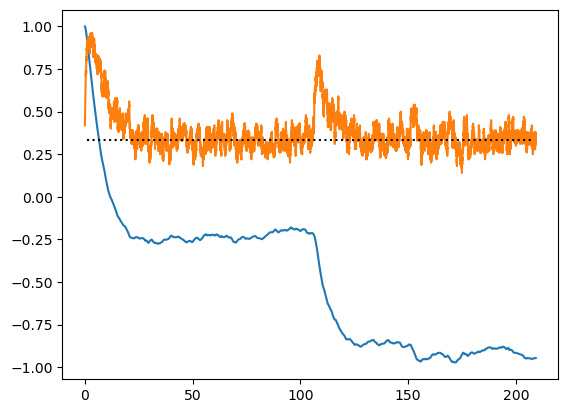

In [4]:
# check whether (de)methylation works
n_sims = 2*10**4
L = 10
km = 0.1
J = 0.1

# initialise randomly
state0 = np.random.choice([-1.,1.], L**2)
state0 = state0.reshape((L,L))

spins, meth, waiting_times = ising_2d_lig_meth_ode(n_sims,state0,L,J,km,step_change=10**4,cbase=100,cnew=10)

plt.plot(np.cumsum(waiting_times), np.mean(meth,axis=(1,2)))
plt.plot(np.cumsum(waiting_times), 0.5+0.5*np.mean(spins,axis=(1,2)))
plt.axhline(y=1/3,xmin=0.05,xmax=0.95,linestyle=':',color='k')
plt.show()

### Methylation Dynamics: Rate Equations

There are three problems with the previous ODE-based approach. Firstly, using an ODE is a rather big departure from our original implementation of a dynamic MWC model, which makes comparison harder. Secondly, all the noise in the methylation only comes from noise in the activity. As such, we may get stochastic resonance or any other unwanted oscillations in the methylation and activity level. Lastly, so far we have not placed a lower or upper bound on the methylation level. Since the physical interpretation of $m_i$ is not straightforward, it is hard to determine appropriate upper and lower bounds. 

An alternative approach may overcome these issues. In the spirit of how we implement the activity dynamics, we turn to a rate-based approach for (de)methylation, much like we did in dynamic implementations of the MWC model. Concretely, demethylation occurs at a constant rate $k_B$, whereas methylation has a rate $k_R$ (the subscripts B and R refer to the kinases CheB and CheR, respectively). Furthermore, only active units can demethylate, and only inactive units can be methylated. In addition, experiments show that each receptor only has a finite number of methylation sites. In our case, we choose this to be four. This places an extra constraint on the dynamics: only sites that have some methyl groups bound can demethylate, and only receptors with fewer than four four methyl groups can methylate. 

In light of this framework, we redefine $m_i \in \{0,1,2,3,4 \}$ as the number of methyl groups bound to site $i$. We translate this into a free energy by introducing $\delta f_m > 0$ as the free-energy benefit per methyl group bound. As such, methylation adds a free-energy term of the form

$$ -\delta f_m \sum_{i=1}^N (m_i-m_0), $$

such that the hamiltonian becomes

$$ \mathcal{H}(\mathbf{s}) = -J\sum_{(i,j)} s_i s_j + \frac{1}{2} f \sum_{i=1}^N s_i -\delta f_m \sum_{i=1}^N (m_i-m_0). $$


Note that we have introduced a baseline methylation level $m_0$. This parameter can be interpreted as the equilibrium methylation level. **Is this a valid addition?** The rates of spin-flipping are then

$$\omega_i = \omega_0 \exp\left\{ -J s_i \sum_{(i,j)}s_j + \frac{1}{2} f s_i - \delta f_m (m_i-m_0) \right\}. $$

We implement this idea using a Gillespie algorithm, as previously. Note that at each time step, a (de)methylation event could take place. The sum of rates $\Omega$ is then

$$\Omega = \sum_{i=1}^N \omega_i + k_B \cdot \# \, \text{sites that can demethylate} + k_R\cdot \#\, \text{sites that can methylate}. $$

In [6]:
@numba.jit(nopython=True)

# this function determines the rates of spin-flipping
# includes (de)methylation energy
def flip_rates_meth(J,H,state,meth_state,omega0=1,delta_fm=2,m0=0.5):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # energy difference due to methylation
    meth_energy = delta_fm*(meth_state-m0)
    
    # return the rates
    return omega0*np.exp(-(coupling + field + meth_energy))

@numba.jit(nopython=True)

# function that finds the (de)methylation rates 
def demethylation_rates(state,meth_state,kR,kB):
    # array to store results
    demeth_rates = np.zeros_like(meth_state,dtype='float64')
    meth_rates = np.zeros_like(meth_state,dtype='float64')
 
    # loop through all receptors and check whether they can (de)methylate        
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            # demethylation
            if state[i,j] == 1 and meth_state[i,j] > 0:
                demeth_rates[i,j] = kB
                
            # methylation
            if state[i,j] == -1 and meth_state[i,j] < 4:
                meth_rates[i,j] = kR

    return demeth_rates, meth_rates

In [7]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ensemble_averaged_meth(n_samples,n_steps,tf,L,J,kR,kB,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):
    
    # array to store all results
    all_states = np.zeros((2,n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over all samples
    for sample in range(n_samples):        
        # intialise each realisation
        dt = 0
        time = 0
        spin_state = np.random.choice(np.array([-1.,1.]),size=(L,L))
        meth_state = np.random.choice(np.arange(0,5),size=(L,L))
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                flip_rates = flip_rates_meth(J,H,spin_state,meth_state)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # perform event based on what type of event occurred
                # spin flip
                if type_index == 0:
                    spin_state[m,l] *= -1

                # demethylation
                elif type_index == 1:
                    meth_state[m,l] += -1

                # methylation
                elif type_index == 2:
                    meth_state[m,l] += 1
                
                # obtain rates of flipping
                flip_rates = flip_rates_meth(J,H,spin_state,meth_state)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
            
            # save the last state before passing the boundary
            all_states[0,sample,step,:,:] = spin_state
            all_states[1,sample,step,:,:] = meth_state
        
    #################
    ### Averaging ###
    #################
    
    # normalise methylation level
    all_states[1,:,:,:,:] *= 0.25
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((2,n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                for k in range(2):
                    ensemble_av[k,step,spin1,spin2] = np.mean(all_states[k,:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

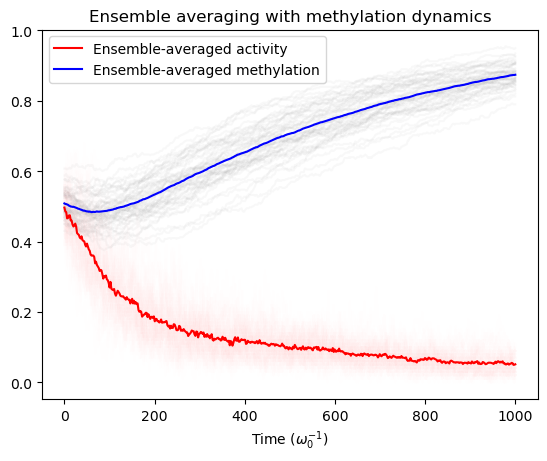

In [8]:
# test if this works
n_samples = 50
n_steps = 500
tf = 10**3
L = 10
J = 0.3
kR = 0.2/25
kB = 0.4/25

all_states, ensemble_av, t_grid = ensemble_averaged_meth(n_samples,n_steps,tf,L,J,kR,kB)

# convert to activity 
ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)

# look at ensemble-averaged activity averaged over all spins for one realisation
for ff in range(n_samples):
    plt.plot(t_grid,0.5+0.5*np.mean(all_states[0,ff,:,:,:],axis=(1,2)),color='pink',alpha=0.01)
    plt.plot(t_grid,np.mean(all_states[1,ff,:,:,:],axis=(1,2)),color='grey',alpha=0.05)
    
plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),color='red',label='Ensemble-averaged activity')
plt.plot(t_grid,np.mean(ensemble_av[1,:,:,:], axis=(1,2)),color='blue',label='Ensemble-averaged methylation')
plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.title('Ensemble averaging with methylation dynamics')
plt.legend()
plt.show()

## Methylation parameters

The way we modelled the methylation-dependent part of the free energy is based on the work by Shimizu et al. (2010). The also determined experimental values for some key parameters: $\langle a \rangle = 1/3$, $m_0 = 0.5$ and $\delta f_m^{Lit} = -2$, where we added the subscript 'Lit' to make clear that this value is taken from the literature. We should, however, be careful with blindly adopting these values into our model, because there are differences between Shimizu et al.'s and our model. 

Concretely, the researchers take the following form for the total free energy,

$$ F^{Lit} = N \ln \frac{1+c/K_i}{1+c/K_a} - \alpha N(m - m_0), $$

with $\alpha = 2$ and $m_0 = 0.5$. The values for $K_i$ and $K_a$ are the same ones we used. In comparison, the free energy in the current model is

$$ F = \sum_{i=1}^N f_i a_i = \sum_{i=1}^N \left(\epsilon_0 + \ln \frac{1+c/K_i}{1+c/K_a} + \delta f_m (m_i-m_0) \right)a_i. $$

The goal of this section is to choose the parameters in a way that makes $F^{Lit}$ and $F$ consistent. For this purpose, we first rewrite the expression for $F$. It is useful to define the lattice-averaged activity $a_0$,

$$ a_0 \equiv \frac{1}{N}\sum_{i=1}^N a_i.$$

This allows working out some of the summations in $F$ after expanding the terms in brackets,

$$ F = \left(\epsilon_0 + \ln \frac{1+c/K_i}{1+c/K_a} \right)\sum_{i=1}^N a_i + \delta f_m \sum_{i=1}^N (m_i - m_0)a_i =\left(\epsilon_0 + \ln \frac{1+c/K_i}{1+c/K_a} \right)Na_0 + \delta f_m \sum_{i=1}^N (m_i - m_0)a_i.$$

This is starting to look similar to $F^{Lit}$, but the methylation terms are problematic still. This is fixed by taking a mean-field approximation, so we assume that the methylation level has settled to some equilibrium value $m^*$ and that fluctuations around this value are negligible; this assumption applies to all spins, so $m_i \approx m^*$ for all $i$. This means that

$$ F = \left(\epsilon_0 + \ln \frac{1+c/K_i}{1+c/K_a} \right)Na_0 + \delta f_m(m^* - m_0)N a_0. $$

It is now possible to insist that at equilibrium, the two models agree, so $F^{Lit} = F$. This leads to the following equation:

$$ \ln \frac{1+c/K_i}{1+c/K_a} - \alpha(m^* - m_0) = \left(\epsilon_0 + \ln \frac{1+c/K_i}{1+c/K_a} \right)a_0 + \delta f_m(m^* - m_0) a_0. $$

There are different ways to solve this equation. We present two approaches.

**First approach.** The most straightforward solution technique is insisting that the concentration- and methylation-dependent parts of the above equation are matched on both sides of the equation. Concretely, this means that we separate the above equation into two parts,

$$\begin{cases} \ln \frac{1+c/K_i}{1+c/K_a} & = \left(\epsilon_0 + \ln \frac{1+c/K_i}{1+c/K_a} \right)a_0 \\ - \alpha(m^* - m_0) & = \delta f_m(m^* - m_0) a_0.
\end{cases} $$

Note that in this way, $\epsilon_0$ and $\delta f_m$ are separated, meaning that each equation can be solved to fix one of these parameters per equation, which leads to 

$$ \boxed{ \epsilon_0 = \frac{1-a_0}{a_0} \ln \frac{1+c/K_i}{1+c/K_a} \quad \mathrm{and} \quad \delta f_m = -\frac{\alpha}{a_0} }. $$

**Second approach.** One remarkable difference between our and Shimizu et al.'s model is that our free energy contains an additional parameter $\epsilon_0$, which simply adds a constant energy per spin. In fact, the term $-\delta f_m m_0$ behaves identically, so it should be possible to 'absorb' $\epsilon_0$ into our choice of $\delta f_m$. Therefore, in this approach we set $\epsilon_0 = 0$ and try to match the other parameters. 

The starting point in this case is

$$ \ln \frac{1+c/K_i}{1+c/K_a} - \alpha(m^* - m_0) = a_0\ln \frac{1+c/K_i}{1+c/K_a} + \delta f_m(m^* - m_0) a_0. $$

Notice that in this case, it is not possible to match the concentration- and methylation-dependent parts independently, as this would lead to $a_0 = 1$, which is not the case. Solving the above for $\delta f_m$ gives

$$ \delta f_m = \frac{1}{m^* - m_0}\frac{1-a_0}{a_0}\ln \frac{1+c/K_i}{1+c/K_a} - \frac{\alpha}{a_0}.$$

What remains to be found is an expression for $m^*-m_0$. To this end, we invoke again a mean-field approximation in the literature model, akin to the approach in Reinhardt et al. (2023). Specifically, since we ignore fluctuations around $a_0$ and $m^*$, we approximate that the probability that a given receptor is active only depends on the average free energy per receptor. In the literature model, this probability amounts to

$$p_a \approx \frac{1}{1 + \exp\{-F^{Lit}/N\}} \approx \left[1 +  \exp\left\{-\ln \frac{1+c/K_i}{1+c/K_a} + \alpha (m^* - m_0)\right\} \right]^{-1}. $$

At equilibrium, this probability equals $a_0$, so this gives an equation that can be solved for $m^* - m_0$, with the result that

$$ m^*-m_0 = \frac{1}{\alpha}\left(\ln \frac{1+c/K_i}{1+c/K_a} + \ln \frac{1-a_0}{a_0} \right). $$

Plugging this into the expression for $\delta f_m$ gives 

$$\delta f_m = \frac{\alpha}{\ln \frac{1+c/K_i}{1+c/K_a} + \ln \frac{1-a_0}{a_0}}\frac{1-a_0}{a_0}\ln \frac{1+c/K_i}{1+c/K_a} - \frac{\alpha}{a_0}. $$

After some algebraic manipulation, this expression translates to

$$\boxed{\delta f_m = -\frac{\alpha}{a_0} \frac{a_0 \ln \frac{1+c/K_i}{1+c/K_a} + \ln \frac{1-a_0}{a_0}}{\ln \frac{1+c/K_i}{1+c/K_a} + \ln \frac{1-a_0}{a_0}}}. $$

Note that this is similar to the result we obtained using the first approach, but with an additional correction factor. Furthermore, it is noteworthy that in both approaches, $m_0$ vanishes from the equations. We take this as evidence that this parameter is similar in both models, so we take the value found by Shimizu et al.: $m_0 = 0.5$.

**Parameters.** With these two approaches at hand, let us plug in numbers to get numerical estimates. Firstly, note that for both approaches, the parameter estimates contain the concentration $c$. For what is to come, it is crucial that we are in the linear regime of the dose-response curve. Therefore, we choose a baseline concentration level $c = 100 \, \mu$M. Furthermore, it has been measured that $a_0 \approx 1/3$ and a typical choice for the binding constants is $K_i = 18 \, \mu$M and $K_a = 2900\, \mu$M. Along with $\alpha = 2$ as found by Shimizu et al., the estimates resulting from the first approach are

$$\epsilon_0 \approx 3.7 \quad \text{and} \quad \delta f_m = -6,  $$

whereas from the second approach, we get

$$\delta f_m \approx -3.1. $$

A priori, we do not see a reason to favour one approach over the other, except that the second approach is simpler in that it contains fewer parameters (because we eliminated $\epsilon_0$). Therefore, we will assess which approach leads to a more reasonable response kernel, which will be the topic of the next section.

In [5]:
# print values
print('Eps0 1st approach:', 2*np.log((1+100/18)/(1+100/2900)))
print('delta fm 2nd approach:', -6*((1/3)*np.log((1+100/18)/(1+100/2900))+np.log(2))/(np.log((1+100/18)/(1+100/2900))+np.log(2)))

Eps0 1st approach: 3.692822629787637
delta fm 2nd approach: -3.0917601335835267
